# The XG Boost Notebook 

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

***What's new?***

Same datapreprocessing and postprocessing as in catboost_day_night_DP.ipynb

We try to change the data preprocessing such that the model only trains and predicts data when is_day = 1. 


When the predictions are ready, we manually insert 0 for every hour when is_day = 0. 

### XHBoost VERSION 1

In [144]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import xgboost as xg
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [145]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [146]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True
            
    threshold = 6

    return sorted([t for t in intervals if t[1] - t[0] >= threshold], key=lambda t: t[1] - t[0], reverse=True)

In [147]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


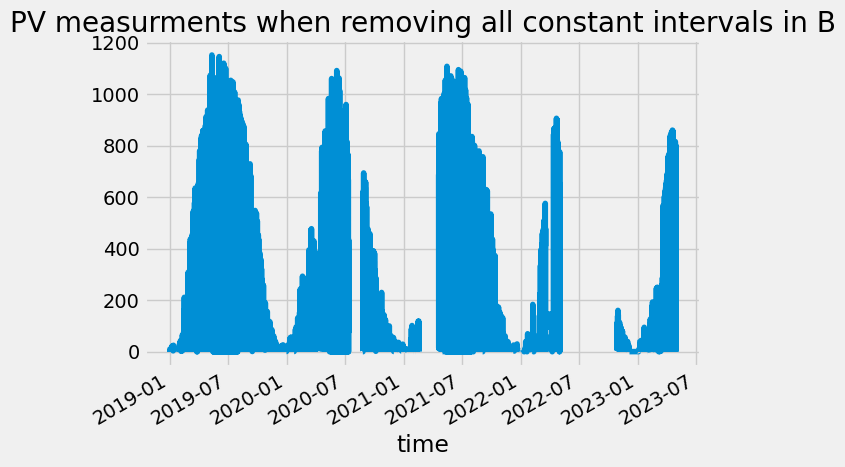

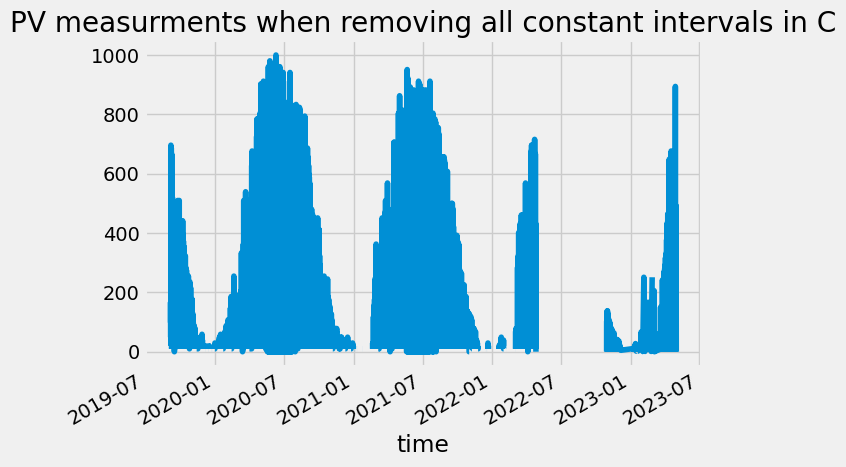

In [148]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [149]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [151]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [152]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [153]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with median.

In [154]:
X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_observed_a.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_observed_a = X_train_observed_a.resample('60min').agg(agg_methods)


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_estimated_a.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_estimated_a = X_train_estimated_a.resample('60min').agg(agg_methods)


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_observed_b.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_observed_b = X_train_observed_b.resample('60min').agg(agg_methods)


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_estimated_b.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_estimated_b = X_train_estimated_b.resample('60min').agg(agg_methods)


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_observed_c.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_observed_c = X_train_observed_c.resample('60min').agg(agg_methods)


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
agg_methods = {col: 'median' for col in X_train_estimated_c.columns}
agg_methods['is_day:idx'] = 'sum'
X_train_estimated_c = X_train_estimated_c.resample('60min').agg(agg_methods)


In [155]:
X_train_estimated_a['is_day:idx'].head()

date_forecast
2022-10-28 22:00:00    0.0
2022-10-28 23:00:00    0.0
2022-10-29 00:00:00    0.0
2022-10-29 01:00:00    0.0
2022-10-29 02:00:00    0.0
Freq: 60T, Name: is_day:idx, dtype: float32

In [156]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [157]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

### Removing 'outlier' features as this gave us 0.1 better score on Kaggle

In [158]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']


for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [159]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [160]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [161]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [162]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.699951,0.0,0.0,1200.699951,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.050049,0.0,0.0,1130.050049,...,0.0,278.349976,85.350006,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.050049,0.0,0.0,1061.050049,...,0.1,278.049988,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [163]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.699951,0.0,0.0,1200.699951,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,255000016.0
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.050049,0.0,0.0,1130.050049,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,265000016.0
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,335000000.0
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,320000000.0
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.050049,0.0,0.0,1061.050049,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,345000000.0


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [164]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [165]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [166]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              40896
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 42788 ROWS BEING DROPPED. THE DATASET HAS 56298 ROWS IN TOTAL.


In [167]:
df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,...,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,location_A,location_B,location_C,estimated,pv_measurement
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 10:00:00,5.70,1.2505,45179.900391,20.65,0.0,275.600006,3.40,7203.199707,0.00,36.849999,...,0,-0.972082,0.234642,56.333199,2061.902588,0,1,0,0,0.000749
2019-01-01 11:00:00,5.60,1.2540,90826.597656,27.10,0.0,275.349976,5.35,15655.649902,0.00,48.600000,...,0,-0.999990,-0.004564,93.738907,2689.675049,0,1,0,0,0.008982
2019-01-01 12:00:00,5.45,1.2570,89853.601562,20.15,0.0,274.899994,7.35,22645.500000,0.20,343.850006,...,0,-0.969915,-0.243446,53.750126,1940.445068,0,1,0,0,0.004491
2019-01-01 13:00:00,5.30,1.2625,42863.000000,2.45,0.0,274.500000,0.95,15217.299805,0.00,294.900009,...,0,-0.885227,-0.465159,0.665175,233.607513,0,1,0,0,0.000749
2019-01-02 10:00:00,4.25,1.2980,46925.400391,21.25,0.0,271.649994,4.60,10360.799805,0.05,50.850000,...,0,-0.971601,0.236626,59.446877,2125.000000,0,1,0,0,0.002994


In [168]:
df.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'hour', 'dayofweek', 'quarter',

## Lets drop nightime rows

In [169]:
test_df = df.copy()

In [170]:
test_df = test_df[test_df['is_day:idx'] > 0]

In [171]:
test_df.shape, df.shape

((39457, 62), (56298, 62))

In [172]:
df = test_df 

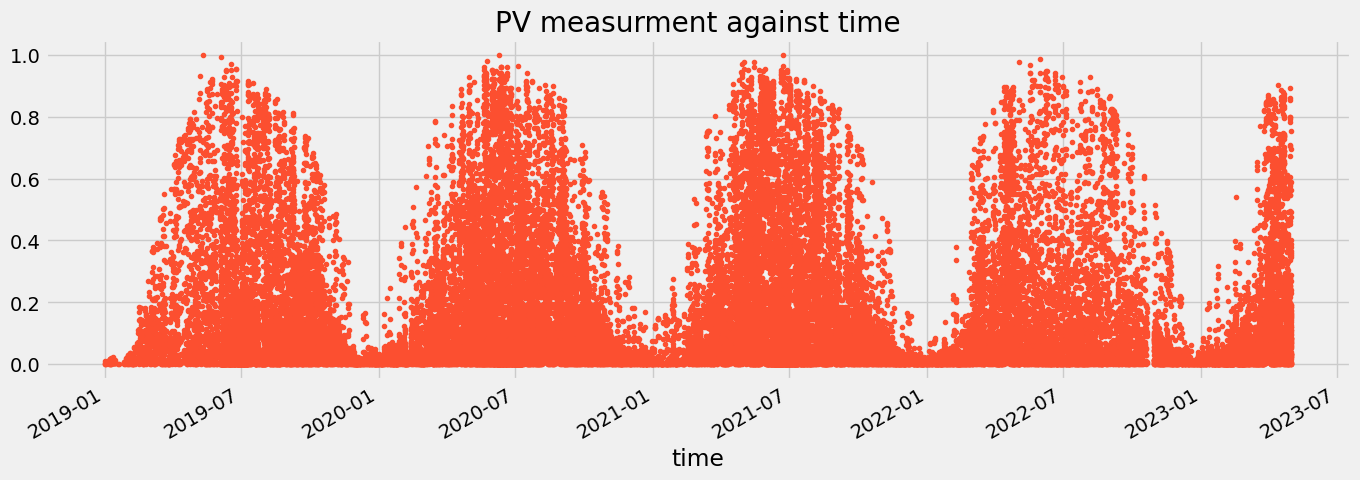

In [173]:
'''
import plotly.graph_objects as go

# Extract the index and values
x_data = df.index
y_data = df["pv_measurement"]

# Create a figure
fig = go.Figure()

# Add line plot
fig.add_trace(go.Scatter(x=x_data, y=y_data,
                         mode='markers',
                         marker=dict(color=color_pal[1]),
                         name='PV Measurement'))

# Set title and labels
fig.update_layout(title='PV Measurement against time',
                  xaxis_title='Time',
                  yaxis_title='PV Measurement')

# Show the figure
fig.show()
'''

color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [174]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    agg_methods = {col: 'median' for col in x_test.columns}
    agg_methods['is_day:idx'] = 'sum'
    x_test = x_test.resample('60min').agg(agg_methods)
 

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1


    x_test = x_test[x_test['is_day:idx'] > 0]   

    return x_test

In [175]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [296]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

valid_dates have nightime dates, we need to remove them

In [297]:
# Find the intersection of indices
common_dates = x_test_a.index.intersection(x_test_b.index).intersection(x_test_c.index)

len(common_dates) * 3


1794

In [298]:
night_time = valid_dates.difference(common_dates)
print(list(night_time))


[Timestamp('2023-05-01 00:00:00'), Timestamp('2023-05-01 01:00:00'), Timestamp('2023-05-01 02:00:00'), Timestamp('2023-05-01 20:00:00'), Timestamp('2023-05-01 21:00:00'), Timestamp('2023-05-01 22:00:00'), Timestamp('2023-05-01 23:00:00'), Timestamp('2023-05-06 00:00:00'), Timestamp('2023-05-06 01:00:00'), Timestamp('2023-05-06 02:00:00'), Timestamp('2023-05-06 20:00:00'), Timestamp('2023-05-06 21:00:00'), Timestamp('2023-05-06 22:00:00'), Timestamp('2023-05-06 23:00:00'), Timestamp('2023-05-14 00:00:00'), Timestamp('2023-05-14 01:00:00'), Timestamp('2023-05-14 21:00:00'), Timestamp('2023-05-14 22:00:00'), Timestamp('2023-05-14 23:00:00'), Timestamp('2023-05-18 00:00:00'), Timestamp('2023-05-18 01:00:00'), Timestamp('2023-05-18 21:00:00'), Timestamp('2023-05-18 22:00:00'), Timestamp('2023-05-18 23:00:00'), Timestamp('2023-05-20 00:00:00'), Timestamp('2023-05-20 01:00:00'), Timestamp('2023-05-20 21:00:00'), Timestamp('2023-05-20 22:00:00'), Timestamp('2023-05-20 23:00:00'), Timestamp('20

In [178]:
x_test_a = x_test_a.loc[common_dates]
x_test_b = x_test_b.loc[common_dates]
x_test_c = x_test_c.loc[common_dates]

In [179]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [180]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows. Now it is 1794 instead if 2160 because we have removed nightime dates. 

In [181]:
if X_test.shape[0] != 1794:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [182]:
X = df[FEATURES]
y = df[TARGET]

# Define parameters you want to tune

NOTE we have gotten issues by tuning too many paramters. Be carefull!

In [183]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import TimeSeriesSplit
import optuna
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


def objective(trial):
    param = {
        "eval_metric": 'mae',  
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 9),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0)
    }

    cv = TimeSeriesSplit(n_splits=3)

    model = xg.XGBRegressor(**param)

    maes = []

    for train_index, val_index in cv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train, verbose=0)
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        maes.append(mae)
        
    avg_mae = np.mean(maes)

    return avg_mae


### Spesify number of trials

A higher number of trials tries out more parameters

In [184]:
trials = 120

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trials, n_jobs=-1, show_progress_bar=True)  

[I 2023-10-25 20:58:35,569] A new study created in memory with name: no-name-05372e8c-90d7-42e3-af4b-393cd2fbbab6


  0%|          | 0/120 [00:00<?, ?it/s]

[I 2023-10-25 20:58:37,302] Trial 7 finished with value: 0.1768506843612975 and parameters: {'lambda': 5.878979026865811e-06, 'alpha': 0.19699325387831515, 'learning_rate': 0.0008070600135878109, 'n_estimators': 76, 'max_depth': 1, 'min_child_weight': 6, 'subsample': 0.8389447836078938, 'colsample_bytree': 0.8887102228187997, 'colsample_bylevel': 0.8460216717175684, 'colsample_bynode': 0.4165200057568434, 'gamma': 0.689484124818417}. Best is trial 7 with value: 0.1768506843612975.
[I 2023-10-25 20:58:43,922] Trial 0 finished with value: 0.18063834144668145 and parameters: {'lambda': 0.0003044867480854474, 'alpha': 0.001620041890088093, 'learning_rate': 0.00011704901873554131, 'n_estimators': 90, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9185747477506442, 'colsample_bytree': 0.5865199241372641, 'colsample_bylevel': 0.4941369610631896, 'colsample_bynode': 0.8985298422792172, 'gamma': 0.6716754396364841}. Best is trial 7 with value: 0.1768506843612975.
[I 2023-10-25 20:58:44,8

In [185]:
best_params = study.best_params
print('Best parameters:', best_params)

#Best parameters: {'iterations': 854, 'learning_rate': 0.017432099489773544, 'depth': 14, 'colsample_bylevel': 0.43559465187532453, 'min_data_in_leaf': 257, 'l2_leaf_reg': 9.179321889625692, 'border_count': 129, 'random_strength': 0.8781261706316226, 'bagging_temperature': 11.599929150721326, 'grow_policy': 'Lossguide', 'max_leaves': 192}

Best parameters: {'lambda': 1.31333011899227e-08, 'alpha': 1.128731151526356e-06, 'learning_rate': 0.011124549692659903, 'n_estimators': 892, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7061500579212828, 'colsample_bytree': 0.7814821085052177, 'colsample_bylevel': 0.9971620334739915, 'colsample_bynode': 0.5212659114834043, 'gamma': 0.0025667955403725906}


### Now visualising the predictions

This is done by using the validation sets from cross validation. We have used Timeseries cross validation with a test size of three months (that which we are trying to predict in our test sets).

In [186]:
model = xg.XGBRegressor(**best_params)

In [187]:
cv = TimeSeriesSplit(n_splits=3, test_size=24*30*3)

residuals = []
predictions = []
actuals = []
dates_list = []  

# Cross-validation loop
for train_index, val_index in cv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    model.fit(X_train, y_train, verbose=0)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Store results
    res = y_val - y_pred
    residuals.extend(res)
    predictions.extend(y_pred)
    actuals.extend(y_val)
    dates_list.extend(X_val.index)

In [188]:
residuals = np.array(residuals)
predictions = np.array(predictions)
actuals = np.array(actuals)

In [189]:
color_pal = sns.color_palette()

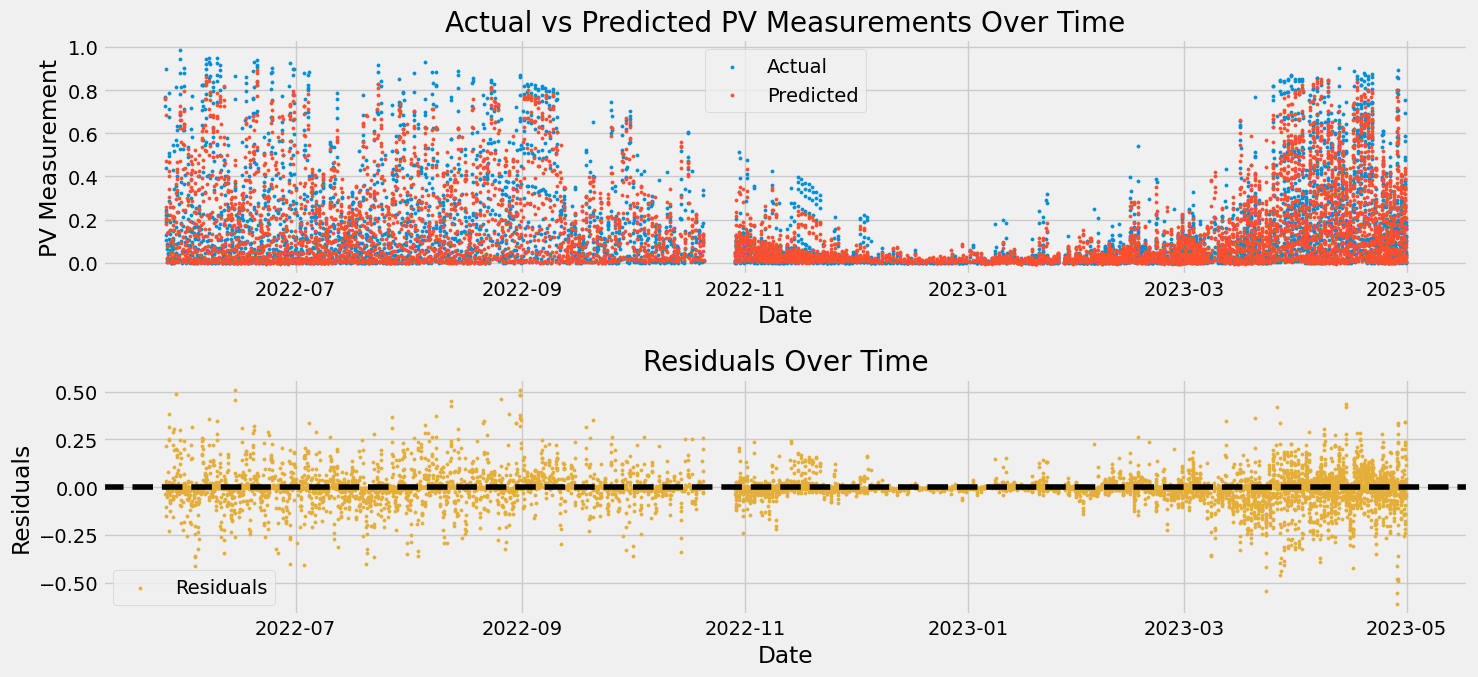

In [190]:
# Scatter Plot for Actual vs Predicted
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.scatter(dates_list, actuals, label='Actual', color=color_pal[0], s=5)  
plt.scatter(dates_list, predictions, label='Predicted', color=color_pal[1], s=5)  
plt.title('Actual vs Predicted PV Measurements Over Time')
plt.xlabel('Date')
plt.ylabel('PV Measurement')
plt.legend()
plt.grid(True)

# Residual Plot
plt.subplot(2, 1, 2)
plt.scatter(dates_list, residuals, label='Residuals', color=color_pal[2], s=5)
plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Here is a box plot to further assist your understanding of the residuals

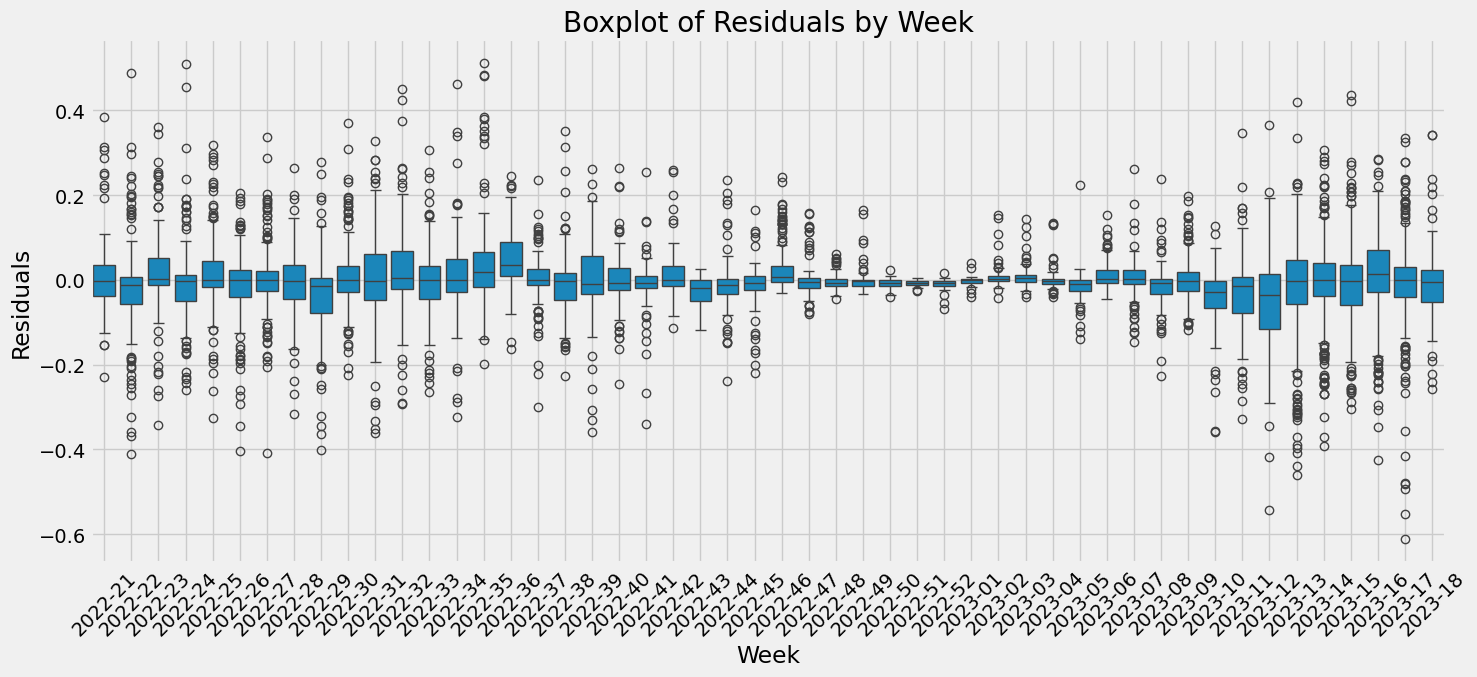

In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with dates and residuals
dfr = pd.DataFrame({
    'Date': pd.to_datetime(dates_list),
    'Residuals': residuals
})

# Extract week number from dates
dfr['Week'] = dfr['Date'].dt.strftime('%Y-%U')

# Box plot using Seaborn
plt.figure(figsize=(15,7))
sns.boxplot(x='Week', y='Residuals', data=dfr)

# Formatting the plot
plt.xticks(rotation=45) # Rotate x-labels for better visibility
plt.title('Boxplot of Residuals by Week')
plt.xlabel('Week')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


# THE MAIN FIGURE TO WORRY ABOUT

### Residual = Actual - Pred

In [192]:
print("The average residuals:")
print(np.mean(residuals))

The average residuals:
-0.0037223048145839967


In [193]:
model.fit(X_train, y_train)

XGBRegressor(alpha=1.128731151526356e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=0.9971620334739915,
             colsample_bynode=0.5212659114834043,
             colsample_bytree=0.7814821085052177, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0025667955403725906,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.31333011899227e-08,
             learning_rate=0.011124549692659903, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=892, n_jobs=None, ...)

### Feature importance

<Axes: >

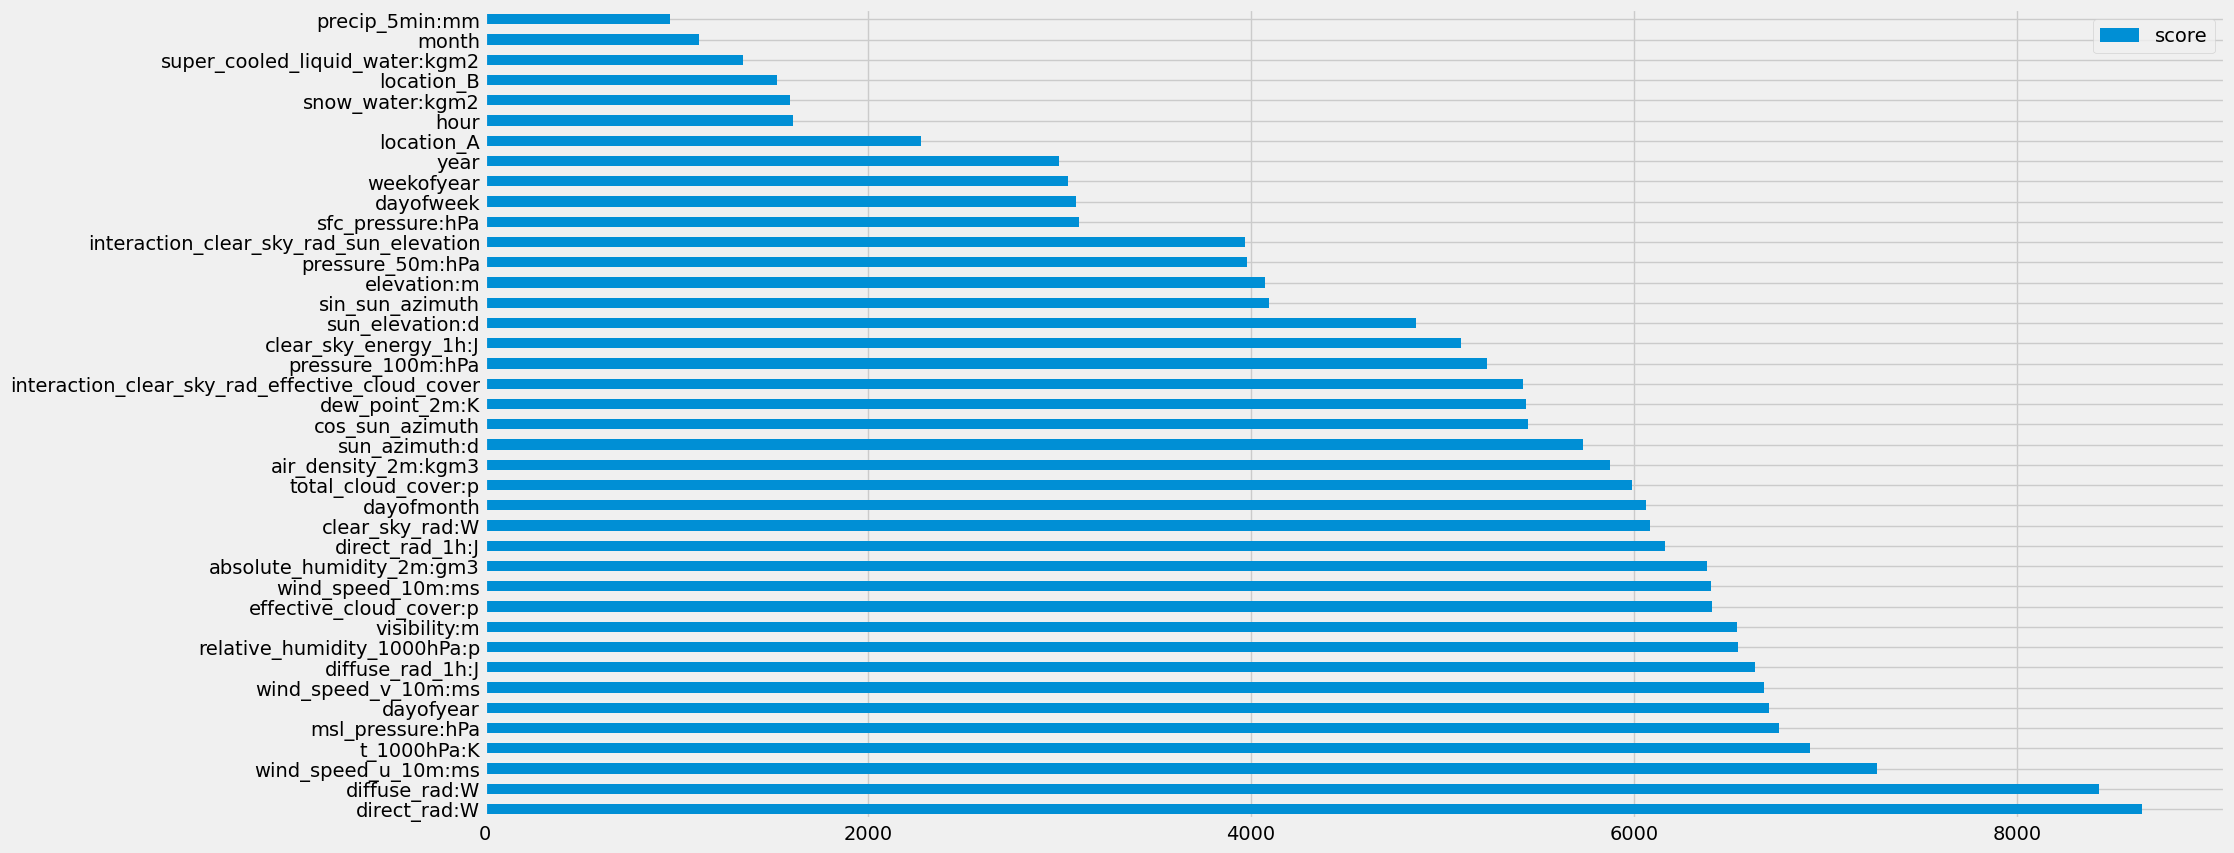

In [194]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) 

### Predict and make csv

In [259]:
predictions = model.predict(X_test)

In [260]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

## Filling in the nightime values with zeroes

In [261]:
all_common_dates = pd.concat([pd.Series(common_dates) for _ in range(3)], ignore_index=True)
predictions['date_forecast'] = all_common_dates

In [262]:
predictions.head()

,prediction,date_forecast
0,0.013124,2023-05-01 03:00:00
1,0.071559,2023-05-01 04:00:00
2,0.164208,2023-05-01 05:00:00
3,0.313401,2023-05-01 06:00:00
4,0.473952,2023-05-01 07:00:00


In [263]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [264]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [265]:
valid_dates_df = pd.DataFrame(valid_dates, columns=['date_forecast'])

loc_a = valid_dates_df.merge(loc_a, on='date_forecast', how='left')
loc_a['prediction'].fillna(0, inplace=True)
loc_a = loc_a.sort_values(by='date_forecast').reset_index(drop=True)

loc_b = valid_dates_df.merge(loc_b, on='date_forecast', how='left')
loc_b['prediction'].fillna(0, inplace=True)
loc_b = loc_b.sort_values(by='date_forecast').reset_index(drop=True)

loc_c = valid_dates_df.merge(loc_c, on='date_forecast', how='left')
loc_c['prediction'].fillna(0, inplace=True)
loc_c = loc_c.sort_values(by='date_forecast').reset_index(drop=True)

In [266]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [267]:
predictions.head(100)

,date_forecast,prediction
0,2023-05-01 00:00:00,0.000000
1,2023-05-01 01:00:00,0.000000
2,2023-05-01 02:00:00,0.000000
3,2023-05-01 03:00:00,75.247078
4,2023-05-01 04:00:00,410.280426
...,...,...
95,2023-05-18 23:00:00,0.000000
96,2023-05-20 00:00:00,0.000000
97,2023-05-20 01:00:00,0.000000
98,2023-05-20 02:00:00,60.457699


In [268]:
predictions.drop('date_forecast', axis=1, inplace=True)

In [269]:
predictions.head(10)

,prediction
0,0.000000
1,0.000000
2,0.000000
3,75.247078
4,410.280426
5,941.475891
6,1796.861206
7,2717.368408
8,2875.257568
9,3076.231934


Renameing the index column to id

In [270]:
predictions.reset_index(drop=True, inplace=True)

Remove negative values

In [272]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=True, index_label='id')

Redifing the training sets

In [225]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

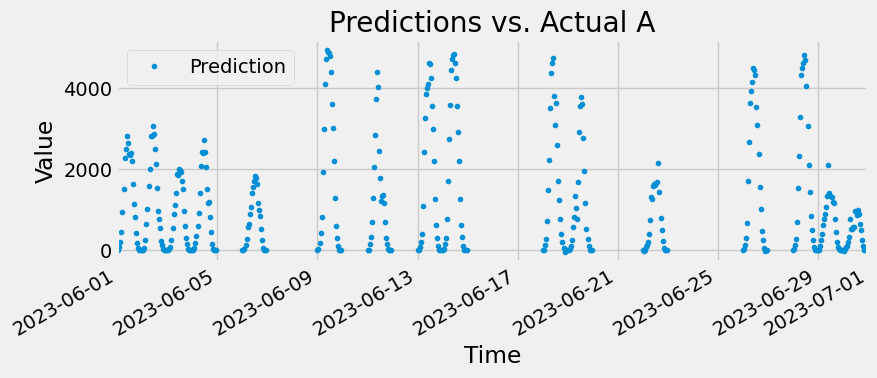

In [279]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction', xlim=('2023-06-01', '2023-07-01'))
#train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

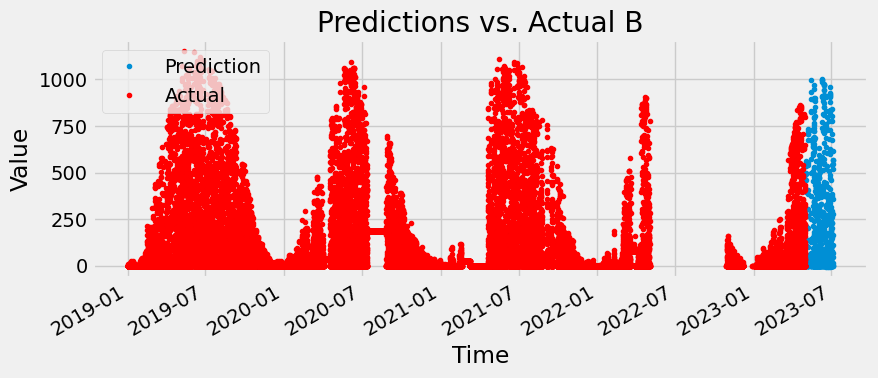

In [227]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


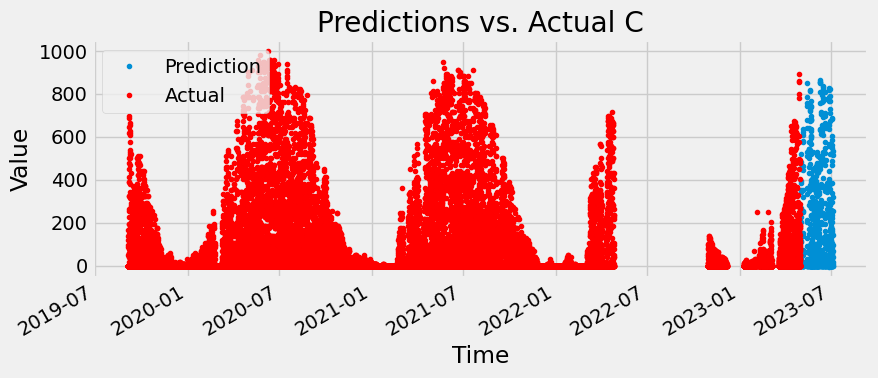

In [228]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()